In [1]:
import os

HOME = os.getcwd()
print(HOME)

/Users/daniel.kaldheim/Projects/Crudus Heima/shop-price-tag


In [6]:
!pip install -q opencv-python
!brew install zbar
!pip install -q pyzbar
!pip install -q easyocr
!pip install -q ultralytics


DEPRECATION: Loading egg at /Users/daniel.kaldheim/.pyenv/versions/3.11.0/lib/python3.11/site-packages/groundingdino-0.1.0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
To reinstall 0.23.93_2, run:
  brew reinstall zbar
DEPRECATION: Loading egg at /Users/daniel.kaldheim/.pyenv/versions/3.11.0/lib/python3.11/site-packages/groundingdino-0.1.0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /Users/daniel.kaldheim/.pyenv/versions/3.11.0/lib/python3.11/site-packages/groundingdino-0.1.0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.

In [3]:
from dotenv import dotenv_values

config = dotenv_values(".env")

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def white_balance(img):
    wbResult = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    avg_a = np.average(wbResult[:, :, 1])
    avg_b = np.average(wbResult[:, :, 2])
    wbResult[:, :, 1] = wbResult[:, :, 1] - (
        (avg_a - 128) * (wbResult[:, :, 0] / 255.0) * 1.1
    )
    wbResult[:, :, 2] = wbResult[:, :, 2] - (
        (avg_b - 128) * (wbResult[:, :, 0] / 255.0) * 1.1
    )
    wbResult = cv2.cvtColor(wbResult, cv2.COLOR_LAB2BGR)
    return wbResult


def order_points(pts):
    """Rearrange coordinates to order:
    top-left, top-right, bottom-right, bottom-left"""
    rect = np.zeros((4, 2), dtype="float32")
    pts = np.array(pts)
    s = pts.sum(axis=1)
    # Top-left point will have the smallest sum.
    rect[0] = pts[np.argmin(s)]
    # Bottom-right point will have the largest sum.
    rect[3] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    # Top-right point will have the smallest difference.
    rect[1] = pts[np.argmin(diff)]
    # Bottom-left will have the largest difference.
    rect[2] = pts[np.argmax(diff)]
    # Return the ordered coordinates.
    return rect.astype("int").tolist()
    #    # approx_corners = [approx_corners[i] for i in [0, 3, 1, 2]]


def shi_tomashi(image):
    """
    Use Shi-Tomashi algorithm to detect corners

    Args:
        image: np.array

    Returns:
        corners: list

    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    corners = cv2.goodFeaturesToTrack(gray, 4, 0.01, 100)
    corners = np.int0(corners)
    corners = sorted(np.concatenate(corners).tolist())
    print("\nThe corner points are...\n")

    im = image.copy()
    for index, c in enumerate(corners):
        x, y = c
        cv2.circle(im, (x, y), 3, 255, -1)
        character = chr(65 + index)
        print(character, ":", c)
        cv2.putText(
            im,
            character,
            tuple(c),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 255, 255),
            2,
            cv2.LINE_AA,
        )

    plt.imshow(im)
    plt.title("Corner Detection: Shi-Tomashi")
    plt.show()
    return corners


def get_destination_points(corners):
    """
    -Get destination points from corners of warped images
    -Approximating height and width of the rectangle: we take maximum of the 2 widths and 2 heights

    Args:
        corners: list

    Returns:
        destination_corners: list
        height: int
        width: int

    """

    w1 = np.sqrt(
        (corners[0][0] - corners[1][0]) ** 2 + (corners[0][1] - corners[1][1]) ** 2
    )
    w2 = np.sqrt(
        (corners[2][0] - corners[3][0]) ** 2 + (corners[2][1] - corners[3][1]) ** 2
    )
    w = max(int(w1), int(w2))

    h1 = np.sqrt(
        (corners[0][0] - corners[2][0]) ** 2 + (corners[0][1] - corners[2][1]) ** 2
    )
    h2 = np.sqrt(
        (corners[1][0] - corners[3][0]) ** 2 + (corners[1][1] - corners[3][1]) ** 2
    )
    h = max(int(h1), int(h2))

    destination_corners = np.float32([(0, 0), (w - 1, 0), (0, h - 1), (w - 1, h - 1)])

    # destination_corners = order_points(destination_corners)

    print("\nThe destination points are: \n")
    for index, c in enumerate(destination_corners):
        character = chr(65 + index) + "'"
        print(character, ":", c)

    print("\nThe approximated height and width of the original image is: \n", (h, w))
    return destination_corners, h, w


def unwarp(img, src, dst):
    """

    Args:
        img: np.array
        src: list
        dst: list

    Returns:
        un_warped: np.array

    """
    h, w = img.shape[:2]
    H, _ = cv2.findHomography(src, dst, method=cv2.RANSAC, ransacReprojThreshold=3.0)
    print("\nThe homography matrix is: \n", H)
    un_warped = cv2.warpPerspective(img, H, (w, h), flags=cv2.INTER_LINEAR)

    # plot

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
    # f.subplots_adjust(hspace=.2, wspace=.05)
    ax1.imshow(img)
    ax1.set_title("Original Image")

    x = [src[0][0], src[2][0], src[3][0], src[1][0], src[0][0]]
    y = [src[0][1], src[2][1], src[3][1], src[1][1], src[0][1]]

    ax2.imshow(img)
    ax2.plot(x, y, color="yellow", linewidth=3)
    ax2.set_ylim([h, 0])
    ax2.set_xlim([0, w])
    ax2.set_title("Target Area")

    plt.show()
    return un_warped


def apply_filter(image):
    """
    Define a 5X5 kernel and apply the filter to gray scale image
    Args:
        image: np.array

    Returns:
        filtered: np.array

    """

    kernel = np.ones((5, 5), np.uint8)
    img = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations=3)

    mask = np.zeros(img.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = (20, 20, img.shape[1] - 20, img.shape[0] - 20)
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype("uint8")
    img = img * mask2[:, :, np.newaxis]

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kernel = np.ones((5, 5), np.float32) / 15
    filtered = cv2.filter2D(gray, -1, kernel)
    plt.imshow(cv2.cvtColor(filtered, cv2.COLOR_BGR2RGB))
    plt.title("Filtered Image")
    plt.show()
    return filtered


def apply_threshold(filtered):
    """
    Apply OTSU threshold

    Args:
        filtered: np.array

    Returns:
        thresh: np.array

    """
    ret, thresh = cv2.threshold(filtered, 250, 255, cv2.THRESH_OTSU)
    plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))
    plt.title("After applying OTSU threshold")
    plt.show()
    return thresh


def detect_contour(img, image_shape):
    """

    Args:
        img: np.array()
        image_shape: tuple

    Returns:
        canvas: np.array()
        cnt: list

    """
    canvas = np.zeros(image_shape, np.uint8)
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    cnt = sorted(contours, key=cv2.contourArea, reverse=True)[0]
    cv2.drawContours(canvas, cnt, -1, (0, 255, 255), 3)
    plt.title("Largest Contour")
    plt.imshow(canvas)
    plt.show()

    return canvas, cnt


def detect_corners_from_contour(canvas, cnt):
    """
    Detecting corner points form contours using cv2.approxPolyDP()
    Args:
        canvas: np.array()
        cnt: list

    Returns:
        approx_corners: list

    """
    epsilon = 0.02 * cv2.arcLength(cnt, True)
    approx_corners = cv2.approxPolyDP(cnt, epsilon, True)
    cv2.drawContours(canvas, approx_corners, -1, (255, 255, 0), 10)
    approx_corners = sorted(np.concatenate(approx_corners).tolist())

    approx_corners = order_points(approx_corners)

    print("\nThe corner points are ...\n")
    for index, c in enumerate(approx_corners):
        character = chr(65 + index)
        print(character, ":", c)
        cv2.putText(
            canvas,
            character,
            tuple(c),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (255, 0, 0),
            2,
            cv2.LINE_AA,
        )

    # Rearranging the order of the corner points
    # approx_corners = [approx_corners[i] for i in [0, 2, 1, 3]]
    # approx_corners = [approx_corners[i] for i in [0, 3, 1, 2]]

    plt.imshow(canvas)
    plt.title("Corner Points: Douglas-Peucker")
    plt.show()
    return approx_corners


def correct_angle(img):
    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # initialize a rectangular and square structuring kernel
    rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 7))

    # smooth the image using a 3x3 Gaussian blur and then apply a
    # blackhat morpholigical operator to find dark regions on a light
    # background
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)

    edges = cv2.Canny(blackhat, 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)

    if lines is None:
        return img

    imgWithAngle = img.copy()
    # lineImg = cv2.cvtColor(croped, cv2.COLOR_GRAY2BGR) # Convert cropped black and white image to color to draw the red line
    angle_degrees = 0
    for rho, theta in lines[0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))

        angle_degrees = np.degrees(theta) - 90

        cv2.line(imgWithAngle, (x1, y1), (x2, y2), (0, 0, 255), 2)  # draw line
        print(f"Rho: {rho}, Theta (degrees): {angle_degrees}")

    if angle_degrees > -45 and angle_degrees < 45:
        M = cv2.getRotationMatrix2D((cX, cY), angle_degrees, 1.0)
        rotated = cv2.warpAffine(img, M, (w, h))
        return rotated, angle_degrees

    return img, angle_degrees


def increase_black_level(image, threshold, increase):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    mask = hsv[:, :, 2] < threshold
    hsv[:, :, 2] = np.where(mask, hsv[:, :, 2] - increase, hsv[:, :, 2])

    new_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return new_img


def list_files(directory):
    with os.scandir(directory) as entries:
        files = [entry.name for entry in entries if entry.is_file()]
    return files

In [5]:
from PIL import Image
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import supervision as sv
from pyzbar.pyzbar import decode
import easyocr


# Load a model
# model = YOLO('yolov8n.pt')  # load an official model
model = YOLO("models/best.pt")  # load a custom model

reader = easyocr.Reader(["no", "en"], verbose=False)

IMAGE_DIR = os.path.join(HOME, "test/rema")
files = list_files(IMAGE_DIR)

for file in files:
    if file == ".DS_Store":
        continue
    IMAGE_PATH = os.path.join(IMAGE_DIR, file)
    cv_image = cv2.imread(IMAGE_PATH)

    plt.imshow(cv_image)
    plt.show()

    # Predict with the model
    results = model(cv_image)  # predict on an image

    for r in results:
        for dim in r.boxes:
            x, y, x1, y1 = dim.xyxy.numpy()[0]
            image = cv_image[round(y) : round(y1), round(x) : round(x1)]
            height, width = image.shape[:2]
            ratio = height / width
            print("Ratio: {}".format(ratio))
            # if ratio >= 0.75 or ratio <= 0.15:  # Filter out partly price tags
            #     continue

            conf = 0.0

            image_float = image.astype(np.float32)

            # alpha: kontrastkontroll (1.0-3.0)
            # beta: lysstyrkekontroll (0-100)
            contrast_image = cv2.convertScaleAbs(image_float, alpha=1.8, beta=50)

            white_balanced = white_balance(contrast_image)

            increase_black_leveled = increase_black_level(white_balanced, 50, 40)

            # kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
            # sharpened_image = cv2.filter2D(white_balanced, -1, kernel)

            # rotated, angle = correct_angle(increase_black_leveled)

            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

            ax1.imshow(image)
            ax1.set_title("Original")
            ax2.imshow(increase_black_leveled)
            ax2.set_title("Rotated")
            plt.show()

            # barcodes = decode(rotated)

            # barcodeImage = rotated.copy()
            # for barcode in barcodes:
            #     # Hent rektangelet som omslutter strekkoden og tegn det på bildet
            #     (x, y, w, h) = barcode.rect
            #     cv2.rectangle(barcodeImage, (x, y), (x + w, y + h), (0, 0, 255), 2)

            #     # Strekkoden er konvertert til en streng
            #     barcodeData = barcode.data.decode("utf-8")
            #     barcodeType = barcode.type

            #     # Tegn strekkode data og strekkode type på bildet
            #     text = "{} ({})".format(barcodeData, barcodeType)
            #     cv2.putText(
            #         barcodeImage,
            #         text,
            #         (x, y - 10),
            #         cv2.FONT_HERSHEY_SIMPLEX,
            #         0.5,
            #         (0, 0, 255),
            #         2,
            #     )

            #     # Skriv ut strekkode type og data til konsollen
            #     print("[INFO] Found {} barcode: {}".format(barcodeType, barcodeData))

            #     plt.title("Barcode")
            #     plt.imshow(barcodeImage)
            #     plt.show()

            # # height, width = rotated.shape[:2]
            # # center = width // 2

            # # left_image = rotated[0:height, 0:center]
            # # right_image = rotated[0:height, center:width]

            # # f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
            # # # f.subplots_adjust(hspace=.2, wspace=.05)
            # # ax1.imshow(left_image)
            # # ax2.imshow(right_image)
            # # plt.show()

            # blurred = cv2.GaussianBlur(rotated, (3, 3), 0)
            # plt.title("Blurred")
            # plt.imshow(blurred)
            # plt.show()

            # article = []
            # confidence = 0
            # detections = reader.readtext(
            #     blurred,
            #     detail=1,
            #     width_ths=0.7,
            #     allowlist="abcdefghijklmnopqrstuwxyzæøåABCDEFGHIJKLMNOPQRSTUWXYZÆØÅ1234567890,./-&% ",
            # )
            # if len(detections) == 0:
            #     continue

            # for d in detections:
            #     article.append(d[-2])
            #     confidence += d[-1]
            # conf = confidence / len(detections)
            # ocr_content = " ".join(article)
            # print(ocr_content)

ModuleNotFoundError: No module named 'easyocr'

loading Roboflow workspace...
loading Roboflow project...


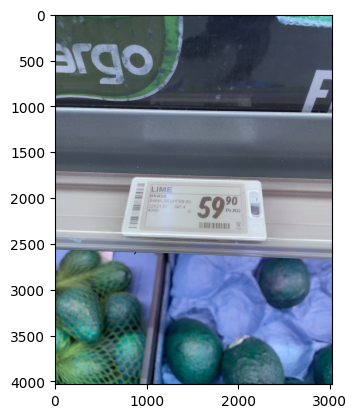

{'predictions': [{'x': 1514.0, 'y': 2108.0, 'width': 1076.0, 'height': 514.0, 'confidence': 0.9420618414878845, 'class': 'price-tags', 'points': [{'x': 1039.5, 'y': 1852.2}, {'x': 1039.5, 'y': 1877.3999999999999}, {'x': 1034.7749999999999, 'y': 1883.7}, {'x': 1034.7749999999999, 'y': 1896.3}, {'x': 1030.05, 'y': 1902.6}, {'x': 1030.05, 'y': 1908.8999999999999}, {'x': 1025.3249999999998, 'y': 1915.2}, {'x': 1025.3249999999998, 'y': 1921.5}, {'x': 1020.5999999999999, 'y': 1927.8}, {'x': 1020.5999999999999, 'y': 2003.3999999999999}, {'x': 1015.8749999999999, 'y': 2009.7}, {'x': 1015.8749999999999, 'y': 2022.3}, {'x': 1006.425, 'y': 2034.8999999999999}, {'x': 1006.425, 'y': 2047.5}, {'x': 1001.6999999999999, 'y': 2053.7999999999997}, {'x': 1001.6999999999999, 'y': 2110.5}, {'x': 996.9749999999999, 'y': 2116.7999999999997}, {'x': 996.9749999999999, 'y': 2129.4}, {'x': 992.2499999999999, 'y': 2135.7}, {'x': 992.2499999999999, 'y': 2142.0}, {'x': 987.525, 'y': 2148.2999999999997}, {'x': 987.5

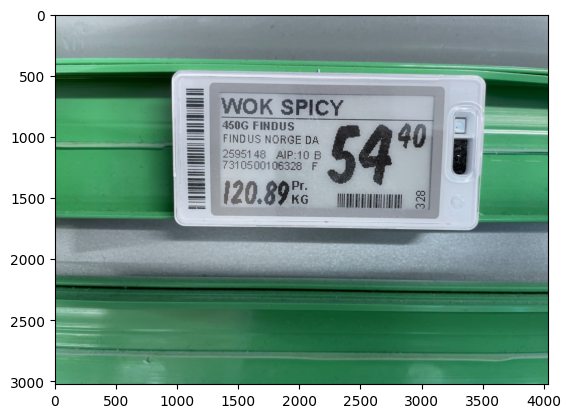

{'predictions': [{'x': 2218.5, 'y': 1123.5, 'width': 1785.0, 'height': 947.0, 'confidence': 0.9487588405609131, 'class': 'price-tags', 'points': [{'x': 1329.3, 'y': 652.05}, {'x': 1329.3, 'y': 732.375}, {'x': 1335.6, 'y': 737.0999999999999}, {'x': 1335.6, 'y': 845.775}, {'x': 1329.3, 'y': 850.4999999999999}, {'x': 1329.3, 'y': 926.0999999999999}, {'x': 1335.6, 'y': 930.8249999999999}, {'x': 1335.6, 'y': 1006.425}, {'x': 1341.8999999999999, 'y': 1011.15}, {'x': 1341.8999999999999, 'y': 1067.85}, {'x': 1335.6, 'y': 1072.5749999999998}, {'x': 1335.6, 'y': 1351.35}, {'x': 1341.8999999999999, 'y': 1356.0749999999998}, {'x': 1341.8999999999999, 'y': 1469.475}, {'x': 1348.2, 'y': 1474.1999999999998}, {'x': 1348.2, 'y': 1488.375}, {'x': 1354.5, 'y': 1493.1}, {'x': 1354.5, 'y': 1521.4499999999998}, {'x': 1360.8, 'y': 1526.175}, {'x': 1360.8, 'y': 1559.2499999999998}, {'x': 1367.1, 'y': 1563.975}, {'x': 1367.1, 'y': 1568.6999999999998}, {'x': 1379.7, 'y': 1568.6999999999998}, {'x': 1386.0, 'y': 

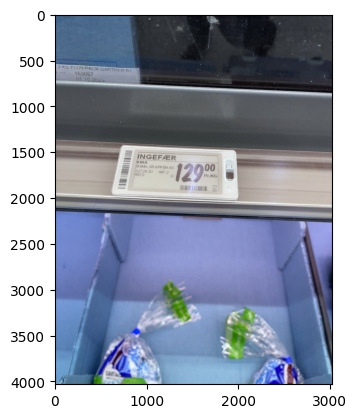

{'predictions': [{'x': 1309.5, 'y': 1719.5, 'width': 953.0, 'height': 447.0, 'confidence': 0.9466506838798523, 'class': 'price-tags', 'points': [{'x': 893.025, 'y': 1499.3999999999999}, {'x': 888.3, 'y': 1505.7}, {'x': 888.3, 'y': 1549.8}, {'x': 883.5749999999999, 'y': 1556.1}, {'x': 883.5749999999999, 'y': 1575.0}, {'x': 874.1249999999999, 'y': 1587.6}, {'x': 874.1249999999999, 'y': 1600.2}, {'x': 869.4, 'y': 1606.5}, {'x': 869.4, 'y': 1669.5}, {'x': 864.675, 'y': 1675.8}, {'x': 864.675, 'y': 1682.1}, {'x': 855.2249999999999, 'y': 1694.7}, {'x': 855.2249999999999, 'y': 1707.3}, {'x': 850.4999999999999, 'y': 1713.6}, {'x': 850.4999999999999, 'y': 1751.3999999999999}, {'x': 845.775, 'y': 1757.7}, {'x': 845.775, 'y': 1764.0}, {'x': 841.05, 'y': 1770.3}, {'x': 841.05, 'y': 1776.6}, {'x': 836.3249999999999, 'y': 1782.8999999999999}, {'x': 836.3249999999999, 'y': 1896.3}, {'x': 841.05, 'y': 1902.6}, {'x': 878.8499999999999, 'y': 1902.6}, {'x': 883.5749999999999, 'y': 1908.8999999999999}, {'

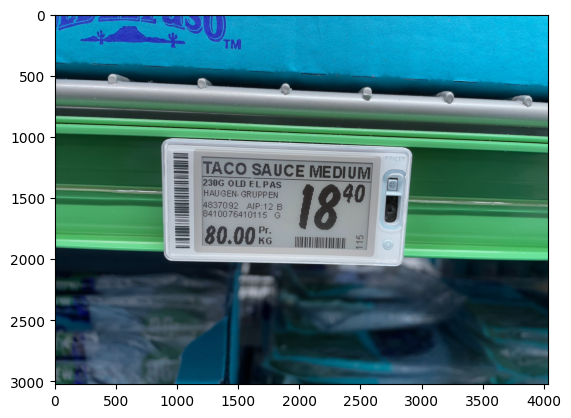

{'predictions': [{'x': 1896.0, 'y': 1541.5, 'width': 1406.0, 'height': 761.0, 'confidence': 0.9514338970184326, 'class': 'price-tags', 'points': [{'x': 1197.0, 'y': 1162.35}, {'x': 1197.0, 'y': 1719.8999999999999}, {'x': 1203.3, 'y': 1724.6249999999998}, {'x': 1203.3, 'y': 1786.05}, {'x': 1197.0, 'y': 1790.7749999999999}, {'x': 1197.0, 'y': 1875.8249999999998}, {'x': 1209.6, 'y': 1885.2749999999999}, {'x': 1215.8999999999999, 'y': 1885.2749999999999}, {'x': 1222.2, 'y': 1889.9999999999998}, {'x': 1297.8, 'y': 1889.9999999999998}, {'x': 1304.1, 'y': 1894.725}, {'x': 1329.3, 'y': 1894.725}, {'x': 1335.6, 'y': 1899.4499999999998}, {'x': 1367.1, 'y': 1899.4499999999998}, {'x': 1373.3999999999999, 'y': 1904.175}, {'x': 1845.8999999999999, 'y': 1904.175}, {'x': 1852.2, 'y': 1908.8999999999999}, {'x': 1990.8, 'y': 1908.8999999999999}, {'x': 1997.1, 'y': 1913.6249999999998}, {'x': 2028.6, 'y': 1913.6249999999998}, {'x': 2034.8999999999999, 'y': 1918.35}, {'x': 2538.9, 'y': 1918.35}, {'x': 2538

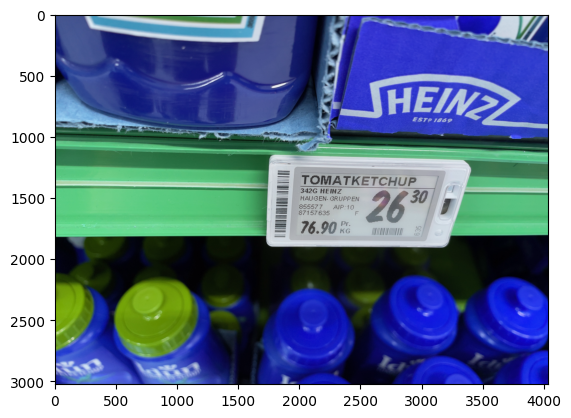

{'predictions': [{'x': 2550.0, 'y': 1560.0, 'width': 1160.0, 'height': 534.0, 'confidence': 0.9634295105934143, 'class': 'price-tags', 'points': [{'x': 1984.5, 'y': 1294.6499999999999}, {'x': 1984.5, 'y': 1304.1}, {'x': 1990.8, 'y': 1308.8249999999998}, {'x': 1990.8, 'y': 1313.55}, {'x': 1984.5, 'y': 1318.2749999999999}, {'x': 1984.5, 'y': 1474.1999999999998}, {'x': 1978.2, 'y': 1478.925}, {'x': 1978.2, 'y': 1512.0}, {'x': 1971.8999999999999, 'y': 1516.725}, {'x': 1971.8999999999999, 'y': 1809.675}, {'x': 2412.9, 'y': 1809.675}, {'x': 2419.2, 'y': 1814.3999999999999}, {'x': 2450.7, 'y': 1814.3999999999999}, {'x': 2457.0, 'y': 1819.1249999999998}, {'x': 2595.6, 'y': 1819.1249999999998}, {'x': 2601.9, 'y': 1823.85}, {'x': 2608.2, 'y': 1823.85}, {'x': 2614.5, 'y': 1819.1249999999998}, {'x': 2702.7, 'y': 1819.1249999999998}, {'x': 2709.0, 'y': 1823.85}, {'x': 2986.2, 'y': 1823.85}, {'x': 2992.5, 'y': 1819.1249999999998}, {'x': 2992.5, 'y': 1800.225}, {'x': 2998.7999999999997, 'y': 1795.499

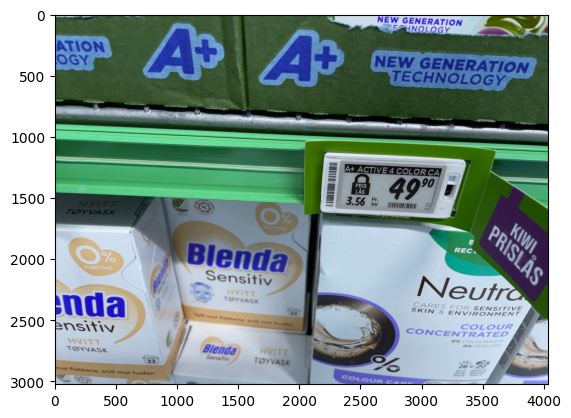

{'predictions': [{'x': 2742.0, 'y': 1414.5, 'width': 852.0, 'height': 395.0, 'confidence': 0.9641139507293701, 'class': 'price-tags', 'points': [{'x': 2362.5, 'y': 1219.05}, {'x': 2362.5, 'y': 1228.5}, {'x': 2356.2, 'y': 1233.225}, {'x': 2356.2, 'y': 1242.675}, {'x': 2349.9, 'y': 1247.3999999999999}, {'x': 2349.9, 'y': 1266.3}, {'x': 2343.6, 'y': 1271.0249999999999}, {'x': 2343.6, 'y': 1389.1499999999999}, {'x': 2337.2999999999997, 'y': 1393.875}, {'x': 2337.2999999999997, 'y': 1412.7749999999999}, {'x': 2331.0, 'y': 1417.5}, {'x': 2331.0, 'y': 1426.9499999999998}, {'x': 2324.7, 'y': 1431.675}, {'x': 2324.7, 'y': 1450.5749999999998}, {'x': 2318.4, 'y': 1455.3}, {'x': 2318.4, 'y': 1563.975}, {'x': 2324.7, 'y': 1563.975}, {'x': 2331.0, 'y': 1568.6999999999998}, {'x': 2356.2, 'y': 1568.6999999999998}, {'x': 2362.5, 'y': 1573.425}, {'x': 2375.1, 'y': 1573.425}, {'x': 2381.4, 'y': 1578.1499999999999}, {'x': 2419.2, 'y': 1578.1499999999999}, {'x': 2425.5, 'y': 1582.8749999999998}, {'x': 2696

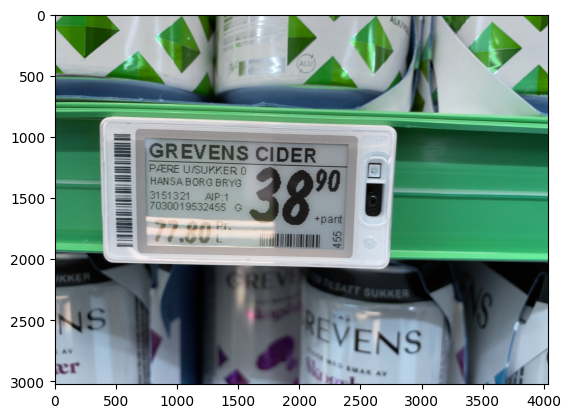

{'predictions': [{'x': 1566.5, 'y': 1470.5, 'width': 1683.0, 'height': 909.0, 'confidence': 0.9458202719688416, 'class': 'price-tags', 'points': [{'x': 730.8, 'y': 1020.5999999999999}, {'x': 730.8, 'y': 1535.6249999999998}, {'x': 737.1, 'y': 1540.35}, {'x': 737.1, 'y': 1587.6}, {'x': 743.4, 'y': 1592.3249999999998}, {'x': 743.4, 'y': 1620.675}, {'x': 749.6999999999999, 'y': 1625.3999999999999}, {'x': 749.6999999999999, 'y': 1634.85}, {'x': 743.4, 'y': 1639.5749999999998}, {'x': 743.4, 'y': 1649.0249999999999}, {'x': 737.1, 'y': 1653.7499999999998}, {'x': 737.1, 'y': 1677.3749999999998}, {'x': 730.8, 'y': 1682.1}, {'x': 730.8, 'y': 1842.7499999999998}, {'x': 737.1, 'y': 1847.475}, {'x': 737.1, 'y': 1880.55}, {'x': 743.4, 'y': 1880.55}, {'x': 749.6999999999999, 'y': 1885.2749999999999}, {'x': 756.0, 'y': 1885.2749999999999}, {'x': 762.3, 'y': 1889.9999999999998}, {'x': 856.8, 'y': 1889.9999999999998}, {'x': 863.1, 'y': 1894.725}, {'x': 882.0, 'y': 1894.725}, {'x': 888.3, 'y': 1899.449999

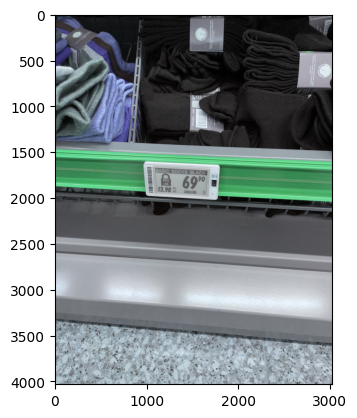

{'predictions': [{'x': 1374.5, 'y': 1827.0, 'width': 579.0, 'height': 308.0, 'confidence': 0.953853964805603, 'class': 'price-tags', 'points': [{'x': 1086.75, 'y': 1675.8}, {'x': 1086.75, 'y': 1852.2}, {'x': 1091.475, 'y': 1858.5}, {'x': 1091.475, 'y': 1927.8}, {'x': 1096.1999999999998, 'y': 1934.1}, {'x': 1096.1999999999998, 'y': 1940.3999999999999}, {'x': 1105.6499999999999, 'y': 1953.0}, {'x': 1138.725, 'y': 1953.0}, {'x': 1143.4499999999998, 'y': 1959.3}, {'x': 1431.675, 'y': 1959.3}, {'x': 1436.3999999999999, 'y': 1965.6}, {'x': 1469.475, 'y': 1965.6}, {'x': 1474.1999999999998, 'y': 1971.8999999999999}, {'x': 1502.55, 'y': 1971.8999999999999}, {'x': 1507.2749999999999, 'y': 1978.2}, {'x': 1653.7499999999998, 'y': 1978.2}, {'x': 1653.7499999999998, 'y': 1971.8999999999999}, {'x': 1658.475, 'y': 1965.6}, {'x': 1658.475, 'y': 1694.7}, {'x': 1653.7499999999998, 'y': 1688.3999999999999}, {'x': 1403.3249999999998, 'y': 1688.3999999999999}, {'x': 1398.6, 'y': 1682.1}, {'x': 1374.975, 'y'

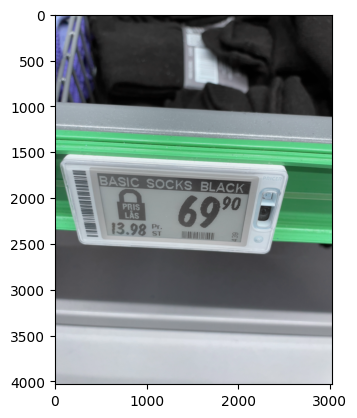

{'predictions': [{'x': 1295.5, 'y': 2121.0, 'width': 1689.0, 'height': 784.0, 'confidence': 0.9224205017089844, 'class': 'price-tags', 'points': [{'x': 453.59999999999997, 'y': 1732.5}, {'x': 453.59999999999997, 'y': 1801.8}, {'x': 458.325, 'y': 1808.1}, {'x': 458.325, 'y': 1814.3999999999999}, {'x': 467.775, 'y': 1827.0}, {'x': 467.775, 'y': 1839.6}, {'x': 472.49999999999994, 'y': 1845.8999999999999}, {'x': 472.49999999999994, 'y': 1896.3}, {'x': 477.22499999999997, 'y': 1902.6}, {'x': 477.22499999999997, 'y': 1915.2}, {'x': 481.95, 'y': 1921.5}, {'x': 481.95, 'y': 1934.1}, {'x': 486.67499999999995, 'y': 1940.3999999999999}, {'x': 486.67499999999995, 'y': 1959.3}, {'x': 491.4, 'y': 1965.6}, {'x': 491.4, 'y': 2022.3}, {'x': 496.12499999999994, 'y': 2028.6}, {'x': 496.12499999999994, 'y': 2041.2}, {'x': 505.575, 'y': 2053.7999999999997}, {'x': 505.575, 'y': 2072.7}, {'x': 510.29999999999995, 'y': 2079.0}, {'x': 510.29999999999995, 'y': 2116.7999999999997}, {'x': 515.025, 'y': 2123.1}, {

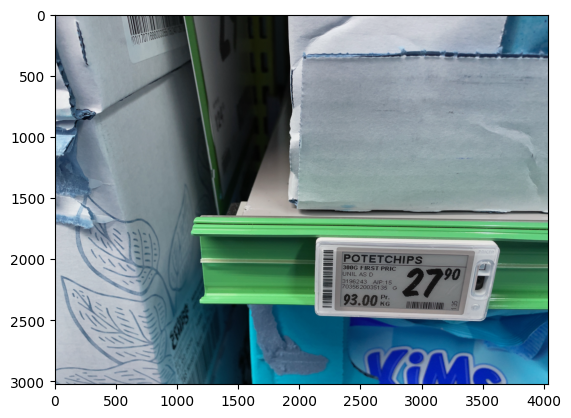

{'predictions': [{'x': 2863.0, 'y': 2183.5, 'width': 1048.0, 'height': 483.0, 'confidence': 0.951038122177124, 'class': 'price-tags', 'points': [{'x': 2343.6, 'y': 1946.6999999999998}, {'x': 2343.6, 'y': 2395.575}, {'x': 2646.0, 'y': 2395.575}, {'x': 2652.2999999999997, 'y': 2400.2999999999997}, {'x': 2702.7, 'y': 2400.2999999999997}, {'x': 2709.0, 'y': 2405.0249999999996}, {'x': 2727.9, 'y': 2405.0249999999996}, {'x': 2734.2, 'y': 2409.75}, {'x': 2778.2999999999997, 'y': 2409.75}, {'x': 2784.6, 'y': 2414.475}, {'x': 3137.4, 'y': 2414.475}, {'x': 3143.7, 'y': 2419.2}, {'x': 3238.2, 'y': 2419.2}, {'x': 3244.5, 'y': 2423.9249999999997}, {'x': 3282.2999999999997, 'y': 2423.9249999999997}, {'x': 3301.2, 'y': 2409.75}, {'x': 3301.2, 'y': 2400.2999999999997}, {'x': 3307.5, 'y': 2395.575}, {'x': 3307.5, 'y': 2386.125}, {'x': 3313.7999999999997, 'y': 2381.3999999999996}, {'x': 3313.7999999999997, 'y': 2371.95}, {'x': 3320.1, 'y': 2367.225}, {'x': 3320.1, 'y': 2329.4249999999997}, {'x': 3313.79

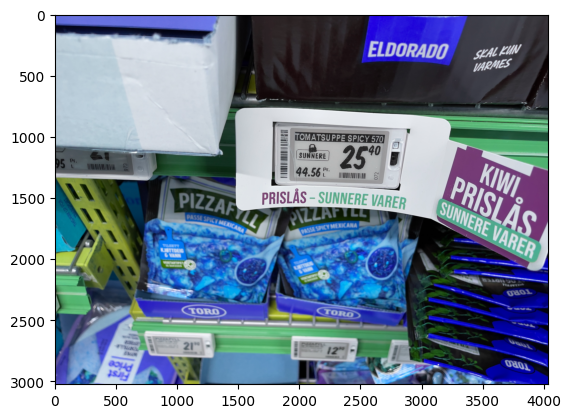

{'predictions': [{'x': 2328.0, 'y': 1164.0, 'width': 758.0, 'height': 410.0, 'confidence': 0.9581867456436157, 'class': 'price-tags', 'points': [{'x': 1953.0, 'y': 963.9}, {'x': 1953.0, 'y': 1346.625}, {'x': 1971.8999999999999, 'y': 1346.625}, {'x': 1978.2, 'y': 1351.35}, {'x': 2060.1, 'y': 1351.35}, {'x': 2066.4, 'y': 1356.0749999999998}, {'x': 2268.0, 'y': 1356.0749999999998}, {'x': 2274.2999999999997, 'y': 1360.8}, {'x': 2520.0, 'y': 1360.8}, {'x': 2526.2999999999997, 'y': 1365.5249999999999}, {'x': 2639.7, 'y': 1365.5249999999999}, {'x': 2652.2999999999997, 'y': 1356.0749999999998}, {'x': 2652.2999999999997, 'y': 1351.35}, {'x': 2658.6, 'y': 1346.625}, {'x': 2658.6, 'y': 1332.4499999999998}, {'x': 2664.9, 'y': 1327.725}, {'x': 2664.9, 'y': 1304.1}, {'x': 2658.6, 'y': 1299.375}, {'x': 2658.6, 'y': 1285.1999999999998}, {'x': 2652.2999999999997, 'y': 1285.1999999999998}, {'x': 2652.2999999999997, 'y': 1289.925}, {'x': 2639.7, 'y': 1299.375}, {'x': 2633.4, 'y': 1299.375}, {'x': 2627.1,

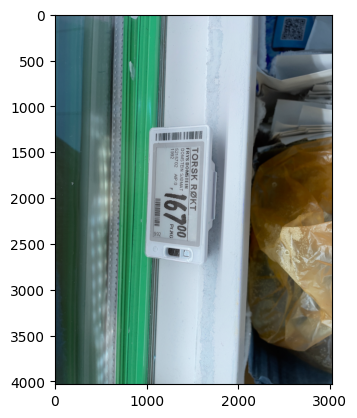

{'predictions': [{'x': 1324.5, 'y': 1966.5, 'width': 511.0, 'height': 1047.0, 'confidence': 0.9516738057136536, 'class': 'price-tags', 'points': [{'x': 1096.1999999999998, 'y': 1449.0}, {'x': 1096.1999999999998, 'y': 1467.8999999999999}, {'x': 1091.475, 'y': 1474.2}, {'x': 1091.475, 'y': 1530.8999999999999}, {'x': 1086.75, 'y': 1537.2}, {'x': 1086.75, 'y': 1732.5}, {'x': 1082.0249999999999, 'y': 1738.8}, {'x': 1082.0249999999999, 'y': 1789.2}, {'x': 1077.3, 'y': 1795.5}, {'x': 1077.3, 'y': 1959.3}, {'x': 1072.5749999999998, 'y': 1965.6}, {'x': 1072.5749999999998, 'y': 1978.2}, {'x': 1077.3, 'y': 1984.5}, {'x': 1077.3, 'y': 2066.4}, {'x': 1072.5749999999998, 'y': 2072.7}, {'x': 1072.5749999999998, 'y': 2438.1}, {'x': 1124.55, 'y': 2438.1}, {'x': 1129.2749999999999, 'y': 2444.4}, {'x': 1148.175, 'y': 2444.4}, {'x': 1152.8999999999999, 'y': 2438.1}, {'x': 1152.8999999999999, 'y': 2419.2}, {'x': 1157.625, 'y': 2412.9}, {'x': 1157.625, 'y': 2387.7}, {'x': 1162.35, 'y': 2381.4}, {'x': 1162.3

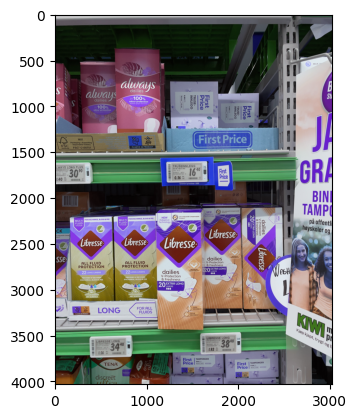

{'predictions': [{'x': 1803.0, 'y': 3591.5, 'width': 314.0, 'height': 175.0, 'confidence': 0.9372295141220093, 'class': 'price-tags', 'points': [{'x': 1649.0249999999999, 'y': 3509.1}, {'x': 1649.0249999999999, 'y': 3672.9}, {'x': 1956.1499999999999, 'y': 3672.9}, {'x': 1956.1499999999999, 'y': 3622.5}, {'x': 1951.425, 'y': 3616.2}, {'x': 1951.425, 'y': 3622.5}, {'x': 1941.975, 'y': 3635.1}, {'x': 1937.2499999999998, 'y': 3635.1}, {'x': 1932.5249999999999, 'y': 3641.4}, {'x': 1927.8, 'y': 3641.4}, {'x': 1923.0749999999998, 'y': 3647.7}, {'x': 1908.8999999999999, 'y': 3647.7}, {'x': 1904.175, 'y': 3654.0}, {'x': 1804.9499999999998, 'y': 3654.0}, {'x': 1790.7749999999999, 'y': 3635.1}, {'x': 1790.7749999999999, 'y': 3559.5}, {'x': 1800.225, 'y': 3546.9}, {'x': 1814.3999999999999, 'y': 3546.9}, {'x': 1819.1249999999998, 'y': 3540.6}, {'x': 1847.475, 'y': 3540.6}, {'x': 1852.1999999999998, 'y': 3534.2999999999997}, {'x': 1856.925, 'y': 3534.2999999999997}, {'x': 1861.6499999999999, 'y': 35

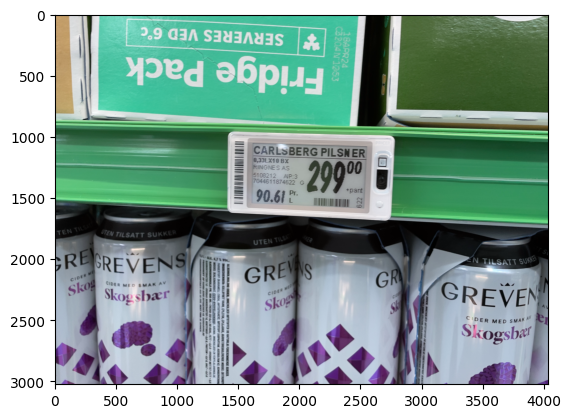

{'predictions': [{'x': 2081.5, 'y': 1324.0, 'width': 951.0, 'height': 544.0, 'confidence': 0.957992672920227, 'class': 'price-tags', 'points': [{'x': 1606.5, 'y': 1053.675}, {'x': 1606.5, 'y': 1549.8}, {'x': 1631.7, 'y': 1549.8}, {'x': 1638.0, 'y': 1554.5249999999999}, {'x': 1669.5, 'y': 1554.5249999999999}, {'x': 1675.8, 'y': 1559.2499999999998}, {'x': 1707.3, 'y': 1559.2499999999998}, {'x': 1713.6, 'y': 1563.975}, {'x': 1908.8999999999999, 'y': 1563.975}, {'x': 1915.2, 'y': 1568.6999999999998}, {'x': 1959.3, 'y': 1568.6999999999998}, {'x': 1965.6, 'y': 1573.425}, {'x': 1984.5, 'y': 1573.425}, {'x': 1990.8, 'y': 1578.1499999999999}, {'x': 2041.2, 'y': 1578.1499999999999}, {'x': 2047.5, 'y': 1582.8749999999998}, {'x': 2349.9, 'y': 1582.8749999999998}, {'x': 2356.2, 'y': 1587.6}, {'x': 2394.0, 'y': 1587.6}, {'x': 2400.2999999999997, 'y': 1592.3249999999998}, {'x': 2526.2999999999997, 'y': 1592.3249999999998}, {'x': 2526.2999999999997, 'y': 1587.6}, {'x': 2532.6, 'y': 1582.8749999999998}

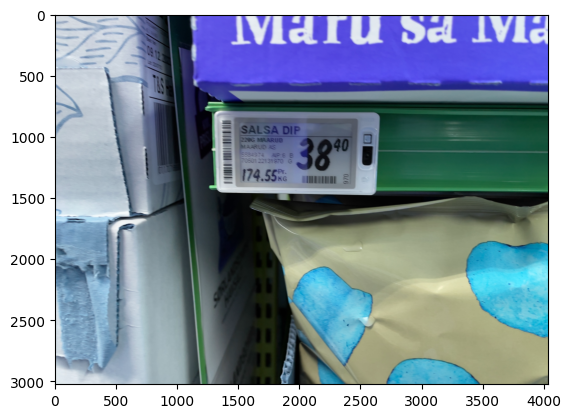

{'predictions': [{'x': 1967.5, 'y': 1135.5, 'width': 925.0, 'height': 501.0, 'confidence': 0.9539827108383179, 'class': 'price-tags', 'points': [{'x': 1505.7, 'y': 888.3}, {'x': 1505.7, 'y': 1370.25}, {'x': 1518.3, 'y': 1379.6999999999998}, {'x': 1537.2, 'y': 1379.6999999999998}, {'x': 1543.5, 'y': 1384.425}, {'x': 1549.8, 'y': 1379.6999999999998}, {'x': 1719.8999999999999, 'y': 1379.6999999999998}, {'x': 1726.2, 'y': 1384.425}, {'x': 2412.9, 'y': 1384.425}, {'x': 2412.9, 'y': 1308.8249999999998}, {'x': 2406.6, 'y': 1304.1}, {'x': 2286.9, 'y': 1304.1}, {'x': 2280.6, 'y': 1308.8249999999998}, {'x': 2053.7999999999997, 'y': 1308.8249999999998}, {'x': 2047.5, 'y': 1313.55}, {'x': 1990.8, 'y': 1313.55}, {'x': 1984.5, 'y': 1308.8249999999998}, {'x': 1978.2, 'y': 1308.8249999999998}, {'x': 1965.6, 'y': 1299.375}, {'x': 1965.6, 'y': 1294.6499999999999}, {'x': 1959.3, 'y': 1289.925}, {'x': 1959.3, 'y': 1011.15}, {'x': 1978.2, 'y': 996.9749999999999}, {'x': 2400.2999999999997, 'y': 996.97499999

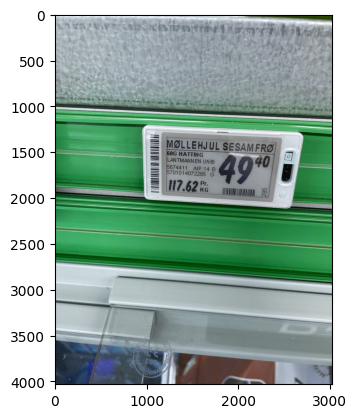

{'predictions': [{'x': 1799.0, 'y': 1675.5, 'width': 1268.0, 'height': 703.0, 'confidence': 0.9298787117004395, 'class': 'price-tags', 'points': [{'x': 1167.0749999999998, 'y': 1329.3}, {'x': 1167.0749999999998, 'y': 1965.6}, {'x': 1204.875, 'y': 1965.6}, {'x': 1209.6, 'y': 1971.8999999999999}, {'x': 1271.0249999999999, 'y': 1971.8999999999999}, {'x': 1275.75, 'y': 1978.2}, {'x': 1360.8, 'y': 1978.2}, {'x': 1365.5249999999999, 'y': 1984.5}, {'x': 1436.3999999999999, 'y': 1984.5}, {'x': 1441.125, 'y': 1990.8}, {'x': 1573.425, 'y': 1990.8}, {'x': 1578.1499999999999, 'y': 1997.1}, {'x': 1705.725, 'y': 1997.1}, {'x': 1710.4499999999998, 'y': 2003.3999999999999}, {'x': 1852.1999999999998, 'y': 2003.3999999999999}, {'x': 1856.925, 'y': 2009.7}, {'x': 1913.6249999999998, 'y': 2009.7}, {'x': 1918.35, 'y': 2016.0}, {'x': 2008.1249999999998, 'y': 2016.0}, {'x': 2012.85, 'y': 2022.3}, {'x': 2353.0499999999997, 'y': 2022.3}, {'x': 2353.0499999999997, 'y': 2016.0}, {'x': 2357.7749999999996, 'y': 20

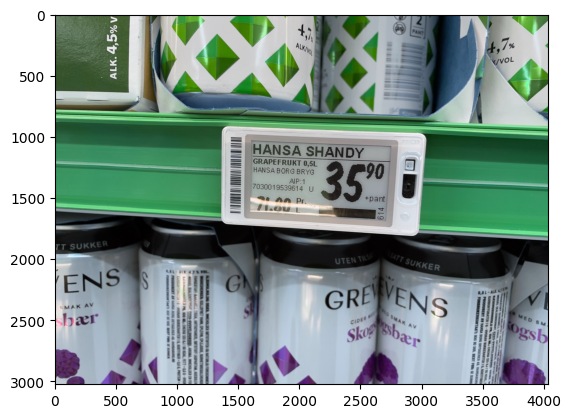

{'predictions': [{'x': 2172.0, 'y': 1371.0, 'width': 1162.0, 'height': 664.0, 'confidence': 0.9564948081970215, 'class': 'price-tags', 'points': [{'x': 1606.5, 'y': 1039.5}, {'x': 1600.2, 'y': 1044.225}, {'x': 1600.2, 'y': 1048.9499999999998}, {'x': 1593.8999999999999, 'y': 1053.675}, {'x': 1593.8999999999999, 'y': 1630.1249999999998}, {'x': 1650.6, 'y': 1630.1249999999998}, {'x': 1656.8999999999999, 'y': 1634.85}, {'x': 1694.7, 'y': 1634.85}, {'x': 1701.0, 'y': 1639.5749999999998}, {'x': 1858.5, 'y': 1639.5749999999998}, {'x': 1864.8, 'y': 1644.3}, {'x': 1915.2, 'y': 1644.3}, {'x': 1921.5, 'y': 1649.0249999999999}, {'x': 1940.3999999999999, 'y': 1649.0249999999999}, {'x': 1946.7, 'y': 1653.7499999999998}, {'x': 1984.5, 'y': 1653.7499999999998}, {'x': 1990.8, 'y': 1658.475}, {'x': 2085.2999999999997, 'y': 1658.475}, {'x': 2091.6, 'y': 1663.1999999999998}, {'x': 2116.7999999999997, 'y': 1663.1999999999998}, {'x': 2123.1, 'y': 1667.925}, {'x': 2135.7, 'y': 1667.925}, {'x': 2142.0, 'y': 1

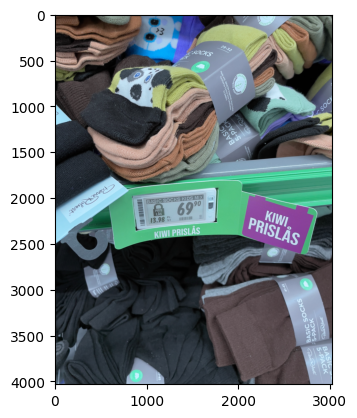

{'predictions': [{'x': 1301.0, 'y': 2127.5, 'width': 636.0, 'height': 325.0, 'confidence': 0.9673374891281128, 'class': 'price-tags', 'points': [{'x': 1417.5, 'y': 1965.6}, {'x': 1412.7749999999999, 'y': 1971.8999999999999}, {'x': 1370.25, 'y': 1971.8999999999999}, {'x': 1365.5249999999999, 'y': 1978.2}, {'x': 1356.0749999999998, 'y': 1978.2}, {'x': 1351.35, 'y': 1984.5}, {'x': 1308.8249999999998, 'y': 1984.5}, {'x': 1304.1, 'y': 1990.8}, {'x': 1124.55, 'y': 1990.8}, {'x': 1119.8249999999998, 'y': 1997.1}, {'x': 1091.475, 'y': 1997.1}, {'x': 1086.75, 'y': 2003.3999999999999}, {'x': 1077.3, 'y': 2003.3999999999999}, {'x': 1072.5749999999998, 'y': 2009.7}, {'x': 1063.125, 'y': 2009.7}, {'x': 1058.3999999999999, 'y': 2016.0}, {'x': 982.8, 'y': 2016.0}, {'x': 982.8, 'y': 2110.5}, {'x': 987.525, 'y': 2116.7999999999997}, {'x': 987.525, 'y': 2123.1}, {'x': 992.2499999999999, 'y': 2129.4}, {'x': 992.2499999999999, 'y': 2135.7}, {'x': 996.9749999999999, 'y': 2142.0}, {'x': 996.9749999999999, '

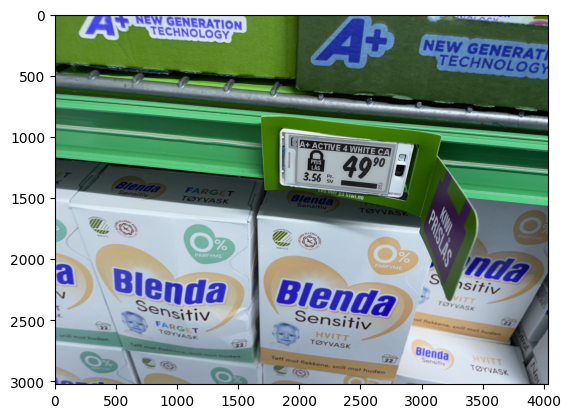

{'predictions': [{'x': 2369.0, 'y': 1232.5, 'width': 790.0, 'height': 425.0, 'confidence': 0.9425458908081055, 'class': 'price-tags', 'points': [{'x': 1978.2, 'y': 1020.5999999999999}, {'x': 1978.2, 'y': 1374.975}, {'x': 2016.0, 'y': 1374.975}, {'x': 2022.3, 'y': 1379.6999999999998}, {'x': 2060.1, 'y': 1379.6999999999998}, {'x': 2066.4, 'y': 1384.425}, {'x': 2085.2999999999997, 'y': 1384.425}, {'x': 2091.6, 'y': 1389.1499999999999}, {'x': 2116.7999999999997, 'y': 1389.1499999999999}, {'x': 2123.1, 'y': 1393.875}, {'x': 2223.9, 'y': 1393.875}, {'x': 2230.2, 'y': 1398.6}, {'x': 2242.7999999999997, 'y': 1398.6}, {'x': 2249.1, 'y': 1403.3249999999998}, {'x': 2261.7, 'y': 1403.3249999999998}, {'x': 2268.0, 'y': 1408.05}, {'x': 2305.7999999999997, 'y': 1408.05}, {'x': 2312.1, 'y': 1412.7749999999999}, {'x': 2400.2999999999997, 'y': 1412.7749999999999}, {'x': 2406.6, 'y': 1417.5}, {'x': 2450.7, 'y': 1417.5}, {'x': 2457.0, 'y': 1422.225}, {'x': 2469.6, 'y': 1422.225}, {'x': 2475.9, 'y': 1426.9

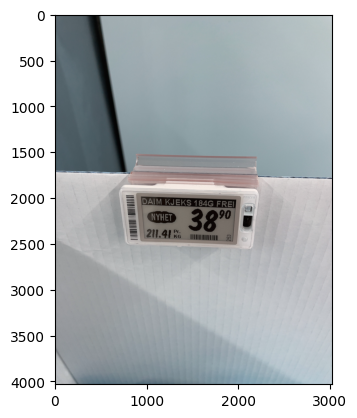

{'predictions': [{'x': 1450.0, 'y': 2240.0, 'width': 1034.0, 'height': 488.0, 'confidence': 0.9316955804824829, 'class': 'price-tags', 'points': [{'x': 935.55, 'y': 1997.1}, {'x': 935.55, 'y': 2142.0}, {'x': 940.275, 'y': 2148.2999999999997}, {'x': 940.275, 'y': 2173.5}, {'x': 944.9999999999999, 'y': 2179.7999999999997}, {'x': 944.9999999999999, 'y': 2255.4}, {'x': 949.7249999999999, 'y': 2261.7}, {'x': 949.7249999999999, 'y': 2280.6}, {'x': 954.4499999999999, 'y': 2286.9}, {'x': 954.4499999999999, 'y': 2299.5}, {'x': 959.175, 'y': 2305.7999999999997}, {'x': 959.175, 'y': 2343.6}, {'x': 963.9, 'y': 2349.9}, {'x': 963.9, 'y': 2431.7999999999997}, {'x': 968.6249999999999, 'y': 2438.1}, {'x': 1072.5749999999998, 'y': 2438.1}, {'x': 1077.3, 'y': 2444.4}, {'x': 1110.375, 'y': 2444.4}, {'x': 1115.1, 'y': 2450.7}, {'x': 1152.8999999999999, 'y': 2450.7}, {'x': 1157.625, 'y': 2457.0}, {'x': 1200.1499999999999, 'y': 2457.0}, {'x': 1204.875, 'y': 2463.2999999999997}, {'x': 1710.4499999999998, 'y'

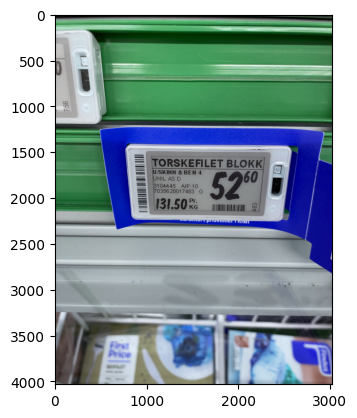

{'predictions': [{'x': 1667.0, 'y': 1855.0, 'width': 1346.0, 'height': 712.0, 'confidence': 0.93694007396698, 'class': 'price-tags', 'points': [{'x': 996.9749999999999, 'y': 1505.7}, {'x': 996.9749999999999, 'y': 1871.1}, {'x': 1001.6999999999999, 'y': 1877.3999999999999}, {'x': 1001.6999999999999, 'y': 1984.5}, {'x': 1006.425, 'y': 1990.8}, {'x': 1006.425, 'y': 2016.0}, {'x': 1011.15, 'y': 2022.3}, {'x': 1011.15, 'y': 2034.8999999999999}, {'x': 1015.8749999999999, 'y': 2041.2}, {'x': 1015.8749999999999, 'y': 2066.4}, {'x': 1020.5999999999999, 'y': 2072.7}, {'x': 1020.5999999999999, 'y': 2135.7}, {'x': 1025.3249999999998, 'y': 2142.0}, {'x': 1025.3249999999998, 'y': 2154.6}, {'x': 1030.05, 'y': 2160.9}, {'x': 1034.7749999999999, 'y': 2160.9}, {'x': 1039.5, 'y': 2167.2}, {'x': 1044.225, 'y': 2167.2}, {'x': 1048.9499999999998, 'y': 2173.5}, {'x': 1072.5749999999998, 'y': 2173.5}, {'x': 1077.3, 'y': 2179.7999999999997}, {'x': 1219.05, 'y': 2179.7999999999997}, {'x': 1223.7749999999999, 'y

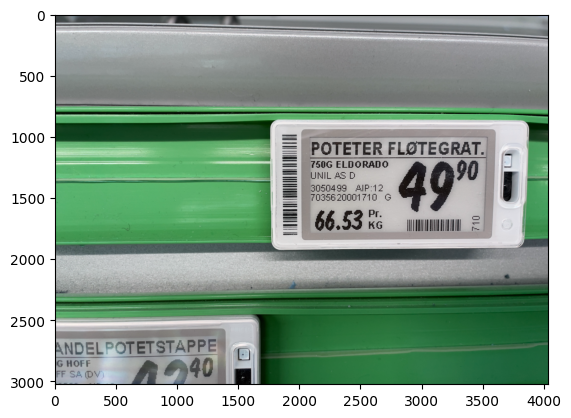

{'predictions': [{'x': 673.0, 'y': 2825.5, 'width': 1340.0, 'height': 391.0, 'confidence': 0.9545893669128418, 'class': 'price-tags', 'points': [{'x': 932.4, 'y': 2631.825}, {'x': 926.1, 'y': 2636.5499999999997}, {'x': 882.0, 'y': 2636.5499999999997}, {'x': 875.6999999999999, 'y': 2641.2749999999996}, {'x': 844.1999999999999, 'y': 2641.2749999999996}, {'x': 837.9, 'y': 2646.0}, {'x': 189.0, 'y': 2646.0}, {'x': 182.7, 'y': 2650.725}, {'x': 138.6, 'y': 2650.725}, {'x': 132.29999999999998, 'y': 2646.0}, {'x': 18.9, 'y': 2646.0}, {'x': 12.6, 'y': 2641.2749999999996}, {'x': 6.3, 'y': 2641.2749999999996}, {'x': 6.3, 'y': 3019.2749999999996}, {'x': 579.6, 'y': 3019.2749999999996}, {'x': 579.6, 'y': 3005.1}, {'x': 585.9, 'y': 3000.375}, {'x': 585.9, 'y': 2962.575}, {'x': 592.1999999999999, 'y': 2957.85}, {'x': 592.1999999999999, 'y': 2924.7749999999996}, {'x': 585.9, 'y': 2920.0499999999997}, {'x': 585.9, 'y': 2910.6}, {'x': 579.6, 'y': 2905.875}, {'x': 579.6, 'y': 2901.1499999999996}, {'x': 5

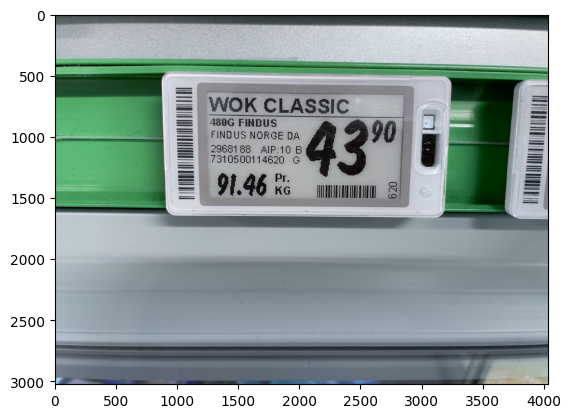

{'predictions': [{'x': 2043.0, 'y': 1075.0, 'width': 1622.0, 'height': 884.0, 'confidence': 0.9387812614440918, 'class': 'price-tags', 'points': [{'x': 1241.1, 'y': 633.15}, {'x': 1234.8, 'y': 637.875}, {'x': 1234.8, 'y': 1020.5999999999999}, {'x': 1241.1, 'y': 1025.3249999999998}, {'x': 1241.1, 'y': 1105.6499999999999}, {'x': 1234.8, 'y': 1110.375}, {'x': 1234.8, 'y': 1214.3249999999998}, {'x': 1241.1, 'y': 1219.05}, {'x': 1241.1, 'y': 1247.3999999999999}, {'x': 1247.3999999999999, 'y': 1252.125}, {'x': 1247.3999999999999, 'y': 1285.1999999999998}, {'x': 1253.7, 'y': 1289.925}, {'x': 1253.7, 'y': 1294.6499999999999}, {'x': 1247.3999999999999, 'y': 1299.375}, {'x': 1247.3999999999999, 'y': 1360.8}, {'x': 1253.7, 'y': 1365.5249999999999}, {'x': 1253.7, 'y': 1417.5}, {'x': 1260.0, 'y': 1422.225}, {'x': 1260.0, 'y': 1483.6499999999999}, {'x': 1272.6, 'y': 1493.1}, {'x': 1278.8999999999999, 'y': 1493.1}, {'x': 1285.2, 'y': 1497.8249999999998}, {'x': 1304.1, 'y': 1497.8249999999998}, {'x': 

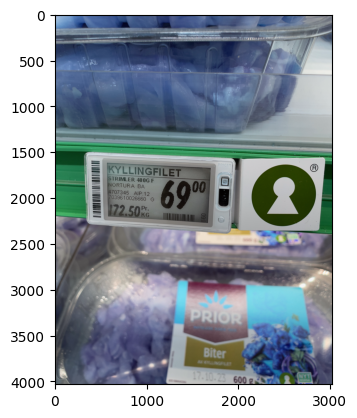

{'predictions': [{'x': 1128.0, 'y': 1938.5, 'width': 1136.0, 'height': 643.0, 'confidence': 0.9463473558425903, 'class': 'price-tags', 'points': [{'x': 562.275, 'y': 1619.1}, {'x': 562.275, 'y': 1953.0}, {'x': 567.0, 'y': 1959.3}, {'x': 567.0, 'y': 2198.7}, {'x': 571.7249999999999, 'y': 2205.0}, {'x': 581.175, 'y': 2205.0}, {'x': 585.9, 'y': 2211.2999999999997}, {'x': 722.925, 'y': 2211.2999999999997}, {'x': 727.65, 'y': 2217.6}, {'x': 789.0749999999999, 'y': 2217.6}, {'x': 793.8, 'y': 2223.9}, {'x': 831.5999999999999, 'y': 2223.9}, {'x': 836.3249999999999, 'y': 2230.2}, {'x': 878.8499999999999, 'y': 2230.2}, {'x': 883.5749999999999, 'y': 2236.5}, {'x': 1242.675, 'y': 2236.5}, {'x': 1247.3999999999999, 'y': 2242.7999999999997}, {'x': 1289.925, 'y': 2242.7999999999997}, {'x': 1294.6499999999999, 'y': 2249.1}, {'x': 1318.2749999999999, 'y': 2249.1}, {'x': 1323.0, 'y': 2255.4}, {'x': 1658.475, 'y': 2255.4}, {'x': 1658.475, 'y': 2205.0}, {'x': 1663.1999999999998, 'y': 2198.7}, {'x': 1663.1

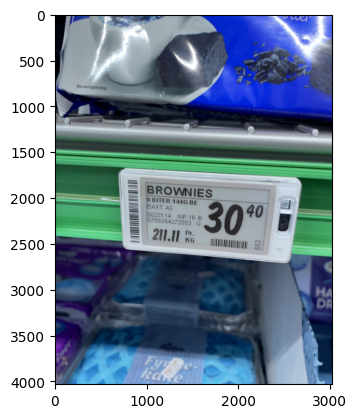

{'predictions': [{'x': 1663.5, 'y': 2201.5, 'width': 1345.0, 'height': 745.0, 'confidence': 0.9506920576095581, 'class': 'price-tags', 'points': [{'x': 992.2499999999999, 'y': 1833.3}, {'x': 992.2499999999999, 'y': 2457.0}, {'x': 996.9749999999999, 'y': 2457.0}, {'x': 1001.6999999999999, 'y': 2463.2999999999997}, {'x': 1025.3249999999998, 'y': 2463.2999999999997}, {'x': 1030.05, 'y': 2469.6}, {'x': 1072.5749999999998, 'y': 2469.6}, {'x': 1077.3, 'y': 2475.9}, {'x': 1091.475, 'y': 2475.9}, {'x': 1096.1999999999998, 'y': 2482.2}, {'x': 1124.55, 'y': 2482.2}, {'x': 1129.2749999999999, 'y': 2488.5}, {'x': 1285.1999999999998, 'y': 2488.5}, {'x': 1289.925, 'y': 2494.7999999999997}, {'x': 1318.2749999999999, 'y': 2494.7999999999997}, {'x': 1323.0, 'y': 2501.1}, {'x': 1341.8999999999999, 'y': 2501.1}, {'x': 1346.625, 'y': 2507.4}, {'x': 1398.6, 'y': 2507.4}, {'x': 1403.3249999999998, 'y': 2513.7}, {'x': 1568.6999999999998, 'y': 2513.7}, {'x': 1573.425, 'y': 2520.0}, {'x': 1639.5749999999998, '

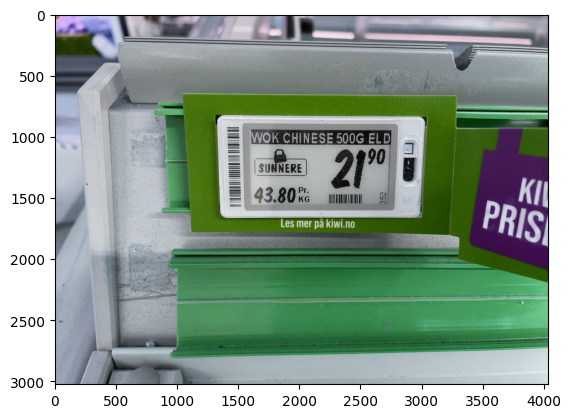

{'predictions': [{'x': 2175.5, 'y': 1251.5, 'width': 1163.0, 'height': 629.0, 'confidence': 0.9579532146453857, 'class': 'price-tags', 'points': [{'x': 1600.2, 'y': 940.275}, {'x': 1600.2, 'y': 1563.975}, {'x': 2016.0, 'y': 1563.975}, {'x': 2022.3, 'y': 1559.2499999999998}, {'x': 2135.7, 'y': 1559.2499999999998}, {'x': 2142.0, 'y': 1563.975}, {'x': 2154.6, 'y': 1563.975}, {'x': 2160.9, 'y': 1559.2499999999998}, {'x': 2356.2, 'y': 1559.2499999999998}, {'x': 2362.5, 'y': 1563.975}, {'x': 2381.4, 'y': 1563.975}, {'x': 2387.7, 'y': 1559.2499999999998}, {'x': 2557.7999999999997, 'y': 1559.2499999999998}, {'x': 2564.1, 'y': 1563.975}, {'x': 2709.0, 'y': 1563.975}, {'x': 2715.2999999999997, 'y': 1559.2499999999998}, {'x': 2715.2999999999997, 'y': 1545.0749999999998}, {'x': 2721.6, 'y': 1540.35}, {'x': 2721.6, 'y': 1455.3}, {'x': 2715.2999999999997, 'y': 1455.3}, {'x': 2709.0, 'y': 1450.5749999999998}, {'x': 2702.7, 'y': 1450.5749999999998}, {'x': 2696.4, 'y': 1455.3}, {'x': 2690.1, 'y': 1455.

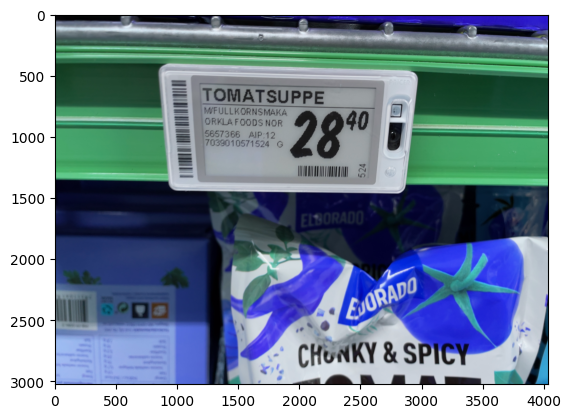

{'predictions': [{'x': 1900.5, 'y': 961.0, 'width': 1451.0, 'height': 792.0, 'confidence': 0.9529820680618286, 'class': 'price-tags', 'points': [{'x': 1178.1, 'y': 567.0}, {'x': 1178.1, 'y': 704.025}, {'x': 1184.3999999999999, 'y': 708.75}, {'x': 1184.3999999999999, 'y': 841.05}, {'x': 1190.7, 'y': 845.775}, {'x': 1190.7, 'y': 1015.8749999999999}, {'x': 1197.0, 'y': 1020.5999999999999}, {'x': 1197.0, 'y': 1044.225}, {'x': 1203.3, 'y': 1048.9499999999998}, {'x': 1203.3, 'y': 1077.3}, {'x': 1209.6, 'y': 1082.0249999999999}, {'x': 1209.6, 'y': 1271.0249999999999}, {'x': 1215.8999999999999, 'y': 1275.75}, {'x': 1215.8999999999999, 'y': 1308.8249999999998}, {'x': 1228.5, 'y': 1318.2749999999999}, {'x': 1234.8, 'y': 1318.2749999999999}, {'x': 1241.1, 'y': 1323.0}, {'x': 1278.8999999999999, 'y': 1323.0}, {'x': 1285.2, 'y': 1327.725}, {'x': 1310.3999999999999, 'y': 1327.725}, {'x': 1316.7, 'y': 1332.4499999999998}, {'x': 1581.3, 'y': 1332.4499999999998}, {'x': 1587.6, 'y': 1337.175}, {'x': 177

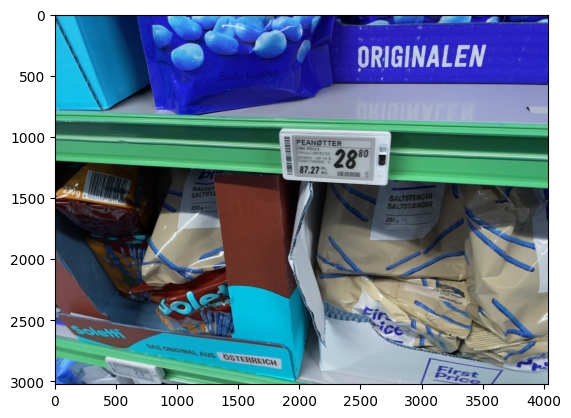

{'predictions': [{'x': 2280.0, 'y': 1177.5, 'width': 642.0, 'height': 335.0, 'confidence': 0.9549983739852905, 'class': 'price-tags', 'points': [{'x': 1959.3, 'y': 1011.15}, {'x': 1959.3, 'y': 1181.25}, {'x': 1965.6, 'y': 1185.975}, {'x': 1965.6, 'y': 1299.375}, {'x': 1971.8999999999999, 'y': 1304.1}, {'x': 1971.8999999999999, 'y': 1308.8249999999998}, {'x': 1978.2, 'y': 1313.55}, {'x': 1984.5, 'y': 1313.55}, {'x': 1990.8, 'y': 1318.2749999999999}, {'x': 2236.5, 'y': 1318.2749999999999}, {'x': 2242.7999999999997, 'y': 1323.0}, {'x': 2261.7, 'y': 1323.0}, {'x': 2268.0, 'y': 1327.725}, {'x': 2280.6, 'y': 1327.725}, {'x': 2286.9, 'y': 1332.4499999999998}, {'x': 2299.5, 'y': 1332.4499999999998}, {'x': 2305.7999999999997, 'y': 1337.175}, {'x': 2538.9, 'y': 1337.175}, {'x': 2545.2, 'y': 1341.8999999999999}, {'x': 2557.7999999999997, 'y': 1341.8999999999999}, {'x': 2564.1, 'y': 1337.175}, {'x': 2576.7, 'y': 1337.175}, {'x': 2583.0, 'y': 1332.4499999999998}, {'x': 2583.0, 'y': 1323.0}, {'x': 2

In [37]:
from roboflow import Roboflow

rf = Roboflow(api_key=config["ROBOFLOW_API_KEY"])
project = rf.workspace().project("price-tags-c79pp")
model = project.version(4).model


IMAGE_DIR = os.path.join(HOME, "test/norges gruppen")
files = list_files(IMAGE_DIR)

for file in files:
    if file == ".DS_Store":
        continue
    IMAGE_PATH = os.path.join(IMAGE_DIR, file)
    cv_image = cv2.imread(IMAGE_PATH)

    plt.imshow(cv_image)
    plt.show()

    print(model.predict(IMAGE_PATH).json())